# EKF Basic test

## Generate Data

In [329]:
from ekf import run_linear_ekf, LinearEkf, State
import numpy as np
import matplotlib.pyplot as plt
from HCW import SimType, SimParams, ThrusterParams, NoiseParams, SatParams, HCWDynamics_3DOF

In [330]:
dt = 0.1
t_max = 10000
t = np.arange(0, t_max, dt)
n_steps = len(t)

In [331]:
# generate_car_data function
def generate_car_data(t, 
                      pos_noise=3.0,     # meters
                      vel_noise=0.5,     # m/s
                      yaw_noise=0.02):   # rad
    """
    Generate smooth car trajectory + noisy observations for EKF testing.
    t : time array (seconds)
    """
    dt = np.diff(t, prepend=t[0])

    # True state arrays
    x = np.zeros_like(t)
    y = np.zeros_like(t)
    yaw = np.zeros_like(t)
    v = np.zeros_like(t)

    # Initial state
    x[0], y[0] = 0.0, 0.0
    yaw[0] = 0.0
    v[0] = 5.0  # m/s

    

    # Generate trajectory
    for i in range(1, len(t)):
        # Smooth acceleration + steering-like behavior
        a = 0.5*np.sin(0.2*t[i]) + np.random.normal(0, .3)  # randomish accel
        omega = 0.3*np.sin(0.1*t[i]) + np.random.normal(0, .1)   # smooth turning rate

        v[i] = v[i-1] + a * dt[i]
        yaw[i] = yaw[i-1] + omega * dt[i]
        x[i] = x[i-1] + v[i] * np.cos(yaw[i]) * dt[i]
        y[i] = y[i-1] + v[i] * np.sin(yaw[i]) * dt[i]

    # True states grouped
    true_state = np.vstack([x, y, yaw, v])

    # Noisy observations (modify as needed)
    z_pos = true_state[:2,:] + np.random.normal(0, pos_noise, (2, len(t)))
    z_vel = true_state[3,:] + np.random.normal(0, vel_noise, len(t))
    z_yaw = true_state[2,:] + np.random.normal(0, yaw_noise, len(t))

    obs = {
        "pos": z_pos.T,
        "vel": z_vel,
        "yaw": z_yaw
    }

    return true_state, obs

(4, 100000)


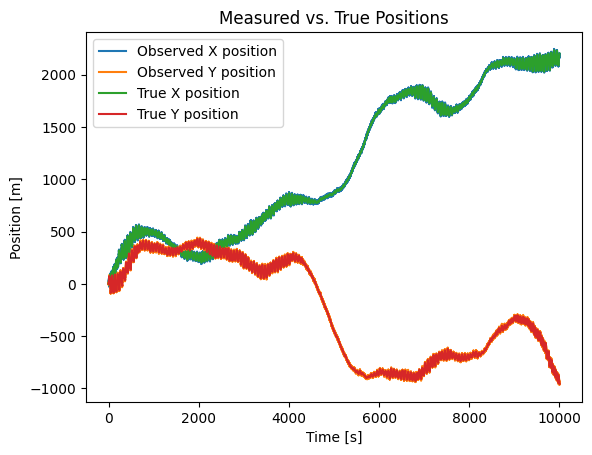

In [332]:
# Generate and plot car data 
x_true, obs = generate_car_data(t, pos_noise=5)

print(x_true.shape)

plt.title("Measured vs. True Positions")
plt.plot(t, obs["pos"], label=("Observed X position","Observed Y position"))
plt.plot(t, x_true[:2].T, label=("True X position","True Y position"))
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.show()


## Linear Kalman Filter

In [333]:
# Linear KF Initialization

# Simple 4d state (x, y, vx, vy)
# Measurement is (x, y)

# State
t = np.arange(0, t_max, dt)
x0 = np.array([0,0,0,0])
P0 = np.diag(np.array([250, 250, 5, 5]))

# Model
F = np.array([
    [0,0,1,0],
    [0,0,0,1],
    [0,0,0,0],
    [0,0,0,0]
])
B = np.array([
    [0,0],
    [0,0],
    [1,0],
    [0,1]
]) # No input but still need something
H = np.array([
    [1,0,0,0],
    [0,1,0,0]
])

# Noise
Q = 10 * np.eye(4) # NOT CORRECTING FOR INPUT BECAUSE WE CANNOT MODEL NONLINEAR
R = .2 * np.eye(2) # Since 2 measurements

linear_ekf = LinearEkf(F, B, H, Q, R)
state = State(x0, P0)


In [334]:
x_arr = np.zeros((n_steps,4))
err = np.zeros((n_steps,2))

for i in range(n_steps):
    z = obs["pos"][i]

    state = run_linear_ekf(state, linear_ekf, None, z) # No input
    x_arr[i,:] = state.x

### Results
As we can see, for these nonlinear dynamics, the linear Kalman Filter does not model 

(100000,)
(100000, 4)


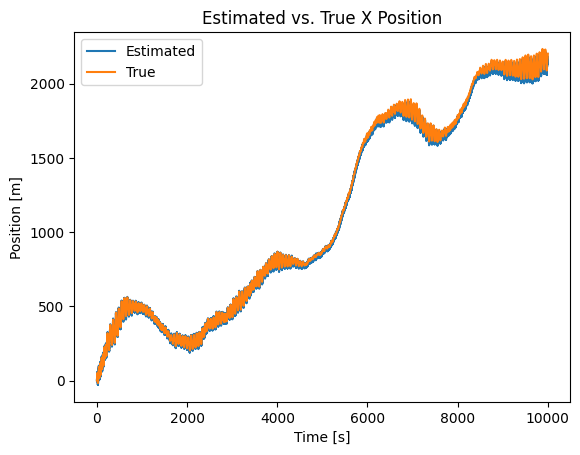

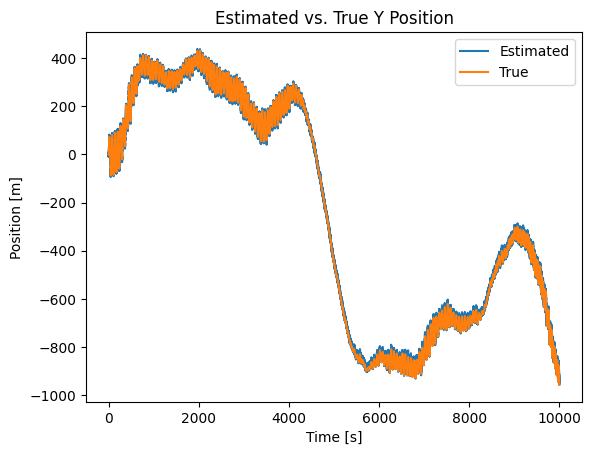

In [335]:
print(t.shape)
print(x_arr.shape)

start = 1
plt.title("Estimated vs. True X Position")
plt.plot(t, x_arr.T[0])
plt.plot(t, x_true[0])
plt.legend(["Estimated","True"])
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.show()


plt.title("Estimated vs. True Y Position")
plt.plot(t, x_arr.T[1])
plt.plot(t, x_true[1])
plt.legend(["Estimated","True"])
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.show()

## Extended Kalman Filter - Good model

In [336]:
from ekf import run_nonlinear_ekf, NonlinearEkf

In [337]:
# EKF Initialization

# Simple 4d state (x, y, yaw, v)
# Measurement is (x, y, v)

# State
t = np.arange(0, t_max, dt)
x0 = np.array([0,0,0,0])
P0 = np.diag(np.array([250, 250, 2, 5]))

def transition_model(state: np.ndarray, u: np.ndarray):  
    x, y, yaw, v = state
    a, omega = u

    return np.array([
        x + v*np.cos(yaw)*dt,
        y + v*np.sin(yaw)*dt,
        yaw + omega*dt,
        v + a*dt
    ])

def get_F(state: np.ndarray):
    _, _, yaw, v = state
    return np.array([
          [1, 0, -v*np.sin(yaw)*dt, np.cos(yaw)*dt],
          [0, 1, v*np.cos(yaw)*dt, np.sin(yaw)*dt],
          [0, 0, 1, 0],
          [0, 0, 0, 1]
    ])

def measurement_model(state: np.ndarray):
    x, y, _, _ = state
    return np.array([x,y]).T

def get_H(_: np.ndarray):
    return np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])


# Noise
Q = np.diag([10, 10, 1, 1]) # NOT CORRECTING FOR INPUT BECAUSE WE CANNOT MODEL NONLINEAR
R = 15 * np.eye(2) # Since 2 measurements

nonlinear_ekf = NonlinearEkf(transition_model, get_F, measurement_model, get_H, Q, R)
state = State(x0, P0)


In [338]:
x_arr = np.zeros((4,n_steps))
err = np.zeros((2,n_steps))

for i in range(n_steps):
    
    # P_arr[i,:] = state.P
    z = obs["pos"][i]
    a = 0.5*np.sin(0.2*t[i])  # randomish accel
    omega = 0.3*np.sin(0.1*t[i])   # smooth turning rate
    u = np.array([a,omega])


    state = run_nonlinear_ekf(state, nonlinear_ekf, u, z)
    x_arr[:,i] = state.x

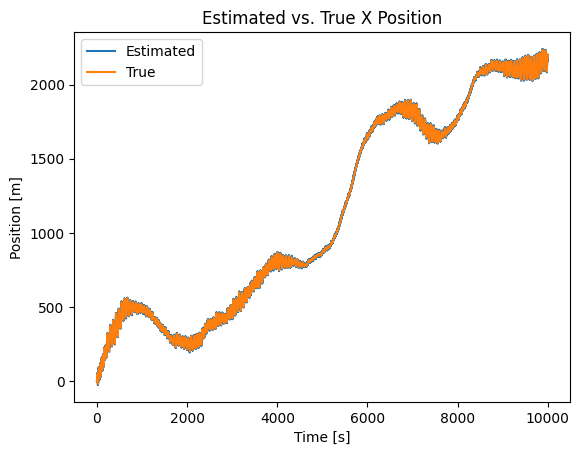

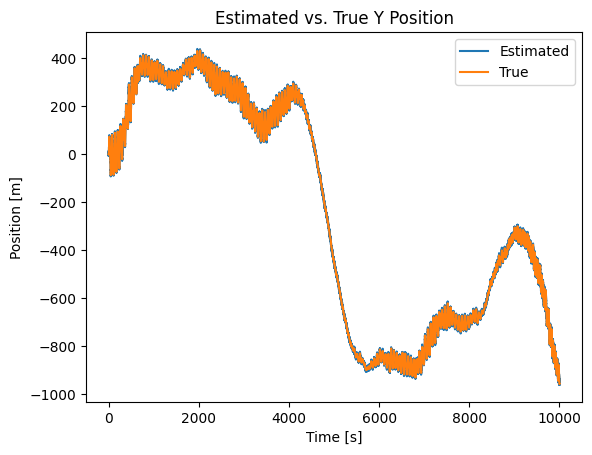

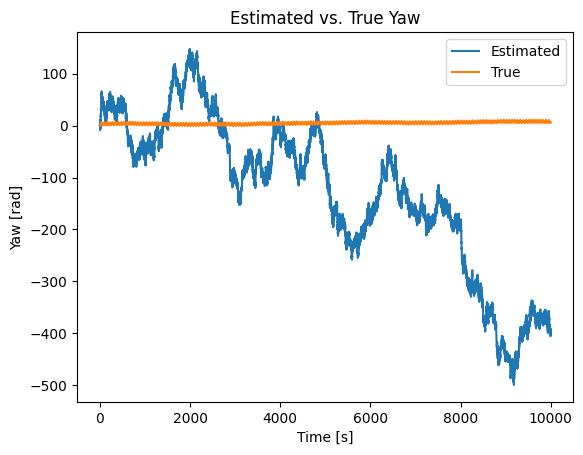

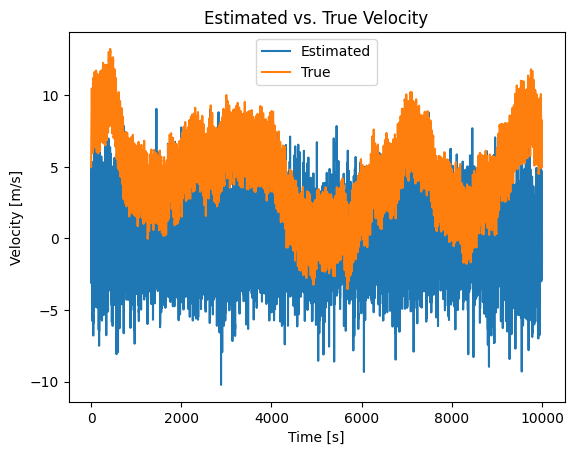

In [339]:
start = 0

plt.title("Estimated vs. True X Position")
plt.plot(t[start:], x_arr[0,start:])
plt.plot(t[start:], x_true[0,start:])
plt.legend(["Estimated","True"])
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.show()


plt.title("Estimated vs. True Y Position")
plt.plot(t[start:], x_arr[1,start:])
plt.plot(t[start:], x_true[1,start:])
plt.legend(["Estimated","True"])
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.show()

# UHHH 
plt.title("Estimated vs. True Yaw")
plt.plot(t, x_arr[2])
plt.plot(t, x_true[2])
plt.legend(["Estimated","True"])
plt.xlabel("Time [s]")
plt.ylabel("Yaw [rad]")
plt.show()

# UHHH 
plt.title("Estimated vs. True Velocity")
plt.plot(t, x_arr[3])
plt.plot(t, x_true[3])
plt.legend(["Estimated","True"])
plt.xlabel("Time [s]")
plt.ylabel("Velocity [m/s]")
plt.show()

## Extended Kalman Filter - Bad Model

In [340]:
# EKF Initialization

# Simple 4d state (x, y, yaw, v)
# Measurement is (x, y)
t = np.arange(0, t_max, dt)
x0 = np.array([0,0,0,0])
P0 = np.diag(np.array([250, 250, 2, 5]))

def transition_model(state: np.ndarray, u: np.ndarray):  
    x, y, yaw, v = state
    a, omega = u

    return np.array([
        x + 2*v*np.cos(yaw)*dt*dt,
        y + v*np.sin(yaw),
        yaw*0.9 + omega*dt,
        0.9*v + a*dt
    ])


# THIS IS MISSING SOME dt in 2 of the measurements
def get_F(state: np.ndarray):
    _, _, yaw, v = state
    return np.array([
          [1, 0, -2*v*np.sin(yaw)*dt*dt, 2*np.cos(yaw)*dt*dt],
          [0, .2, v*np.cos(yaw)*dt, np.sin(yaw)*dt],
          [0, 0, 0.9, 0],
          [0, 0, 0, 0.9]
    ])

def measurement_model(state: np.ndarray):
    x, y, _, _ = state
    return np.array([x,y]).T

def get_H(_: np.ndarray):
    return np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])


# Noise
Q = np.diag([10, 10, 0.1, 1])
R = 7 * np.eye(2) # Since 2 measurements

nonlinear_ekf = NonlinearEkf(transition_model, get_F, measurement_model, get_H, Q, R)
state = State(x0, P0)


In [341]:
x_arr = np.zeros((4,n_steps))
err = np.zeros((2,n_steps))

for i in range(n_steps):
    
    # P_arr[i,:] = state.P
    z = obs["pos"][i]

    omega = 0.5*np.sin(0.1*t[i])  # randomish accel
    a = 0.3*np.cos(0.1*t[i])   # smooth turning rate
    u = np.array([a,omega])


    state = run_nonlinear_ekf(state, nonlinear_ekf, u, z)
    x_arr[:,i] = state.x

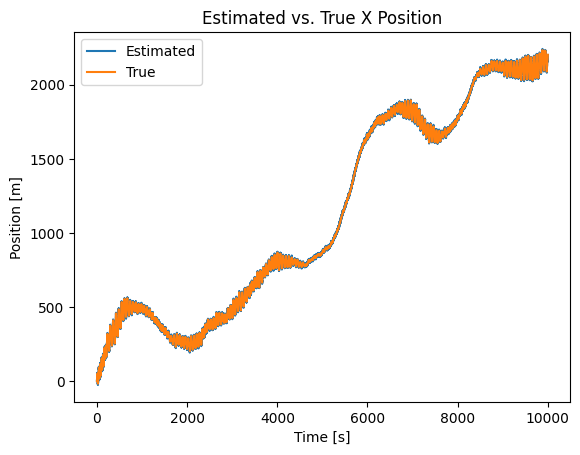

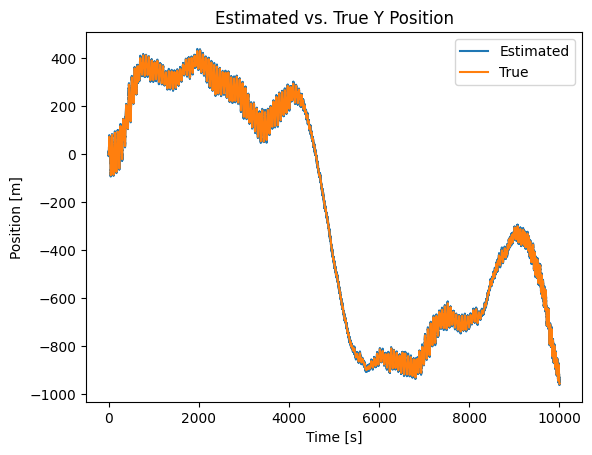

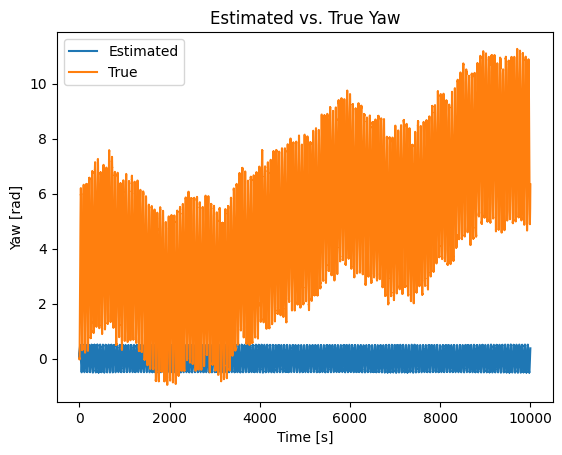

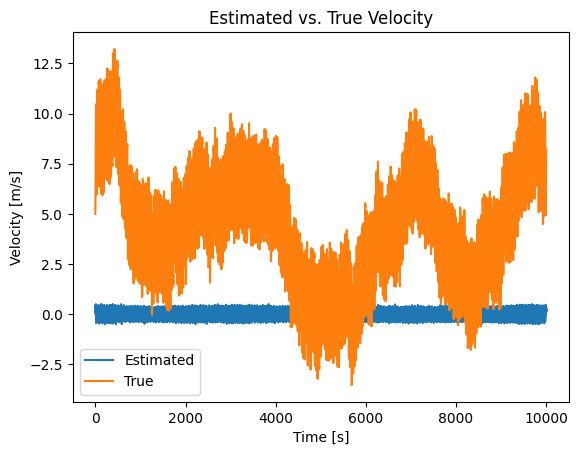

In [342]:
start = 0

plt.title("Estimated vs. True X Position")
plt.plot(t[start:], x_arr[0,start:])
plt.plot(t[start:], x_true[0,start:])
plt.legend(["Estimated","True"])
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.show()


plt.title("Estimated vs. True Y Position")
plt.plot(t[start:], x_arr[1,start:])
plt.plot(t[start:], x_true[1,start:])
plt.legend(["Estimated","True"])
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.show()

# UHHH 
plt.title("Estimated vs. True Yaw")
plt.plot(t, x_arr[2])
plt.plot(t, x_true[2])
plt.legend(["Estimated","True"])
plt.xlabel("Time [s]")
plt.ylabel("Yaw [rad]")
plt.show()

# UHHH 
plt.title("Estimated vs. True Velocity")
plt.plot(t, x_arr[3])
plt.plot(t, x_true[3])
plt.legend(["Estimated","True"])
plt.xlabel("Time [s]")
plt.ylabel("Velocity [m/s]")
plt.show()

# HCW!

## Generate Data

In [353]:


# Satellite
main_thruster = ThrusterParams(5.0, 1)
rcs_thruster = ThrusterParams(0.2, 0.001)
sat = SatParams(mass_kg=500, thrusters=[main_thruster, rcs_thruster])

# Simulation
noise = NoiseParams(sigma_accel=0.1, sigma_pos=10, sigma_vel=2)
sim = SimParams(dt=2.0, n_steps=800, noise=noise, mean_motion_rad_s=0.0011)

x0 = np.array([500.0, 0.0, 0.0,
                0.0,   0.0, 0.0])

# Measurement Model 

# Position-only measurements --> state [x,y,z,vx,vy,vz] to measurements [x,y,z]
# y_k = [x, y, z]^T + noise
# H picks out just the position part from [x, y, z, xdot, ydot, zdot]^T
H = np.hstack([np.eye(3), np.zeros((3, 3))])

# Measurement noise covariance for position-only sensor
# Each axis has variance sigma_p^2, no cross-correlation.
R = (noise.sigma_pos**2) * np.eye(3)

hcw_dynamics = HCWDynamics_3DOF(sim, sat, x0)
X, Y, Y_meas, err, U_meas = hcw_dynamics.simulate(H, R, rng_seed=None, simtype=SimType.mass_varying_with_thrust)

Created simulation lasting 1600.00 sec (26.67 min) with 800 steps
Simulated!


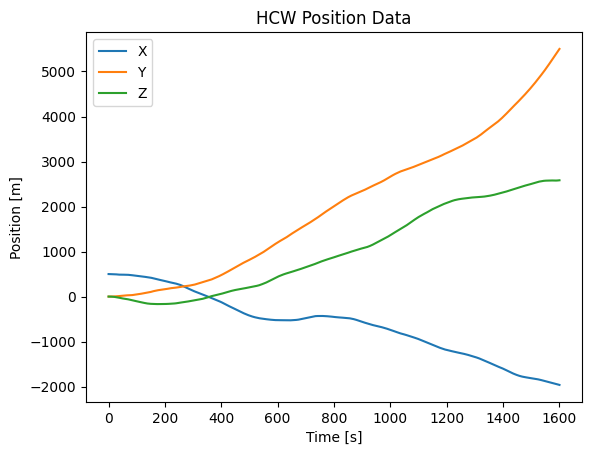

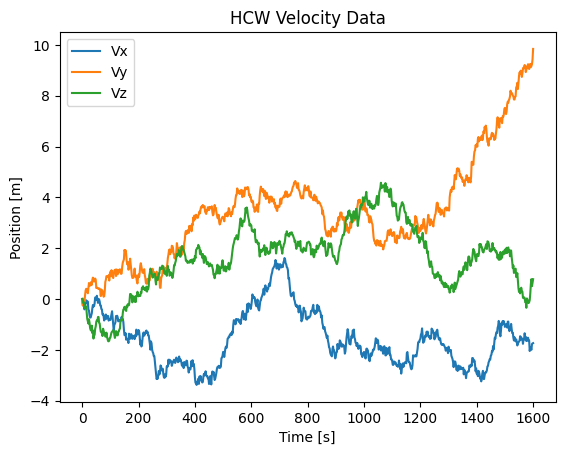

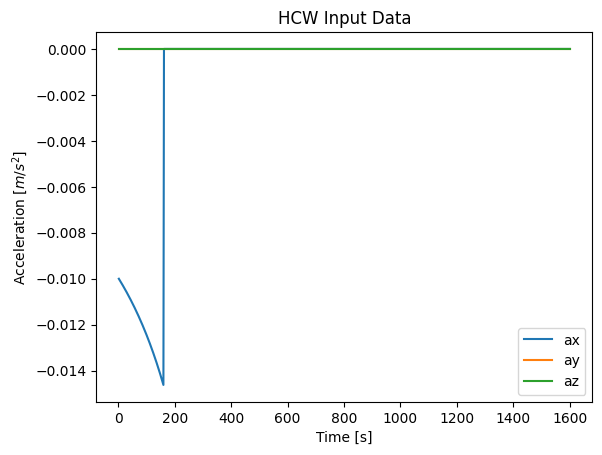

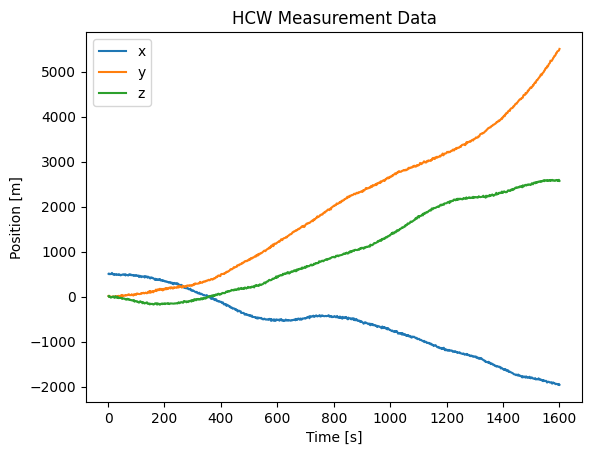

In [354]:
plt.plot(hcw_dynamics.t_array, X[:,:3])
plt.title("HCW Position Data")
plt.legend(["X", "Y", "Z", "Vx", "Vy", "Vz"])
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.show()

plt.plot(hcw_dynamics.t_array, X[:,3:])
plt.title("HCW Velocity Data")
plt.legend(["Vx", "Vy", "Vz"])
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.show()

plt.plot(hcw_dynamics.t_array[1:], U_meas)
plt.title("HCW Input Data")
plt.legend(["ax", "ay", "az"])
plt.xlabel("Time [s]")
plt.ylabel(r"Acceleration [$m/s^2$]")
plt.show()

plt.plot(hcw_dynamics.t_array[1:], Y_meas)
plt.title("HCW Measurement Data")
plt.legend(["x", "y", "z"])
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.show()

## Linear Kalman Filter

In [355]:
# Linear KF Initialization

# 6d state (x, y, z, vx, vy, vz)
# Input is (ax, ay, az)
# Measurement is (x, y, z)

# State
# Real state is x0 = np.array([500.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# Want to make it interesting
x0 = np.array([500.0, 0.0, 0.0, 0.0, 0.0, 0.0])
P0 = np.diag(np.array([10, 10, 10, 5, 5, 5]))
dt, n = sim.dt, sim.n

# Model
F = np.array([
    [0, 0, 0, dt, 0, 0],
    [0, 0, 0, 0, dt, 0],
    [0, 0, 0, 0, 0, dt],
    [3*n*n*dt, 0, 0, 0, 2*n*dt, 0],
    [0, 0, 0, -2*n*dt, 0, 0],
    [0, 0, -n*n, 0, 0, 0]
])

B = np.array([
    [0,0,0],
    [0,0,0],
    [0,0,0],
    [dt,0,0],
    [dt,0,0],
    [0,dt,0]
])

H = np.array([
    [1,0,0,0,0,0],
    [0,1,0,0,0,0],
    [0,0,1,0,0,0],

])

# Noise
Q = 1000 * np.eye(6)
R = 10 * np.eye(3) # Since 2 measurements

linear_ekf = LinearEkf(F, B, H, Q, R)
state = State(x0, P0)


In [356]:
n_steps = sim.N

x_arr = np.zeros((n_steps+1,6))
x_arr[0] = x0
err = np.zeros((n_steps+1,3))

# X, Y, Y_meas, err, U_meas

for i in range(n_steps):
    
    # P_arr[i,:] = state.P
    # z = obs["pos"][i]

    state = run_linear_ekf(state, linear_ekf, U_meas[i], Y_meas[i])
    x_arr[i+1,:] = state.x


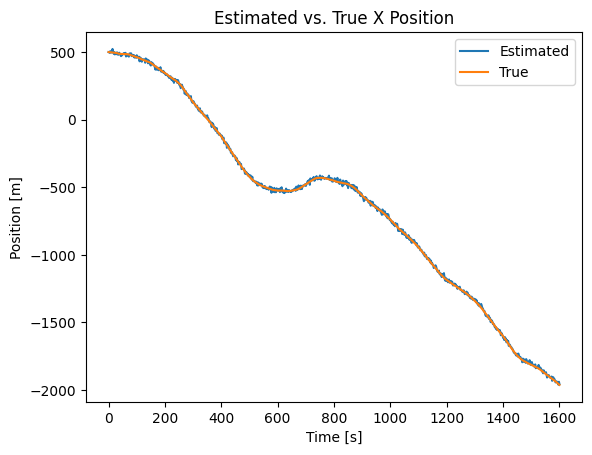

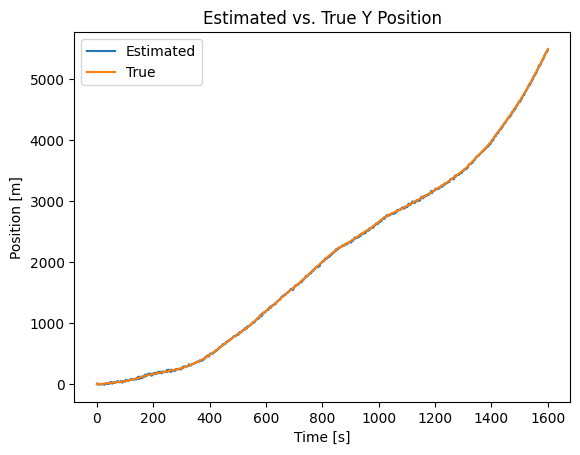

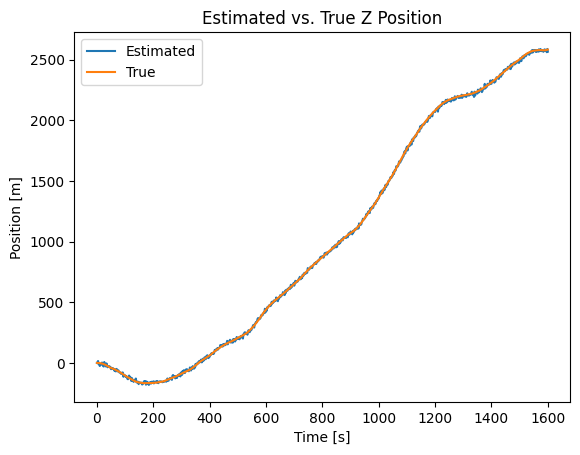

In [357]:
t = hcw_dynamics.t_array

start = 1
plt.title("Estimated vs. True X Position")
plt.plot(t, x_arr.T[0])
plt.plot(t, X[:,0])
plt.legend(["Estimated","True"])
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.show()


plt.title("Estimated vs. True Y Position")
plt.plot(t, x_arr.T[1])
plt.plot(t, X[:,1])
plt.legend(["Estimated","True"])
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.show()

plt.title("Estimated vs. True Z Position")
plt.plot(t, x_arr.T[2])
plt.plot(t, X[:,2])
plt.legend(["Estimated","True"])
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.show()




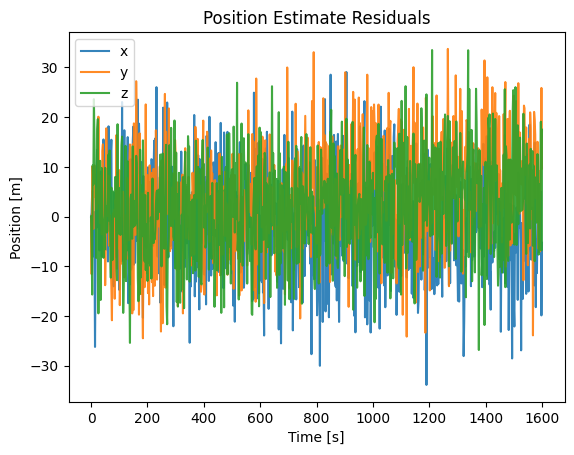

RMS error per axis (position):
x: 10.315314653063147
y: 11.16135272180143
z: 10.130659219862988


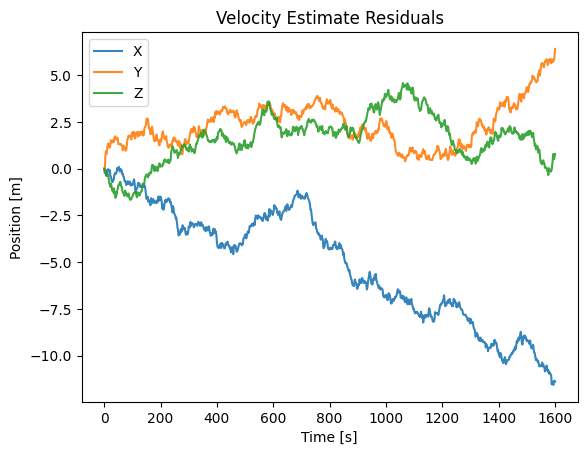

RMS error per axis (velocity):
x: 5.978703713451998
y: 2.63871232517665
z: 2.099866394538933


In [358]:
# Error analysis
err = X - x_arr

plt.title("Position Estimate Residuals")
plt.plot(t, err[:,:3], alpha=0.9)
plt.legend(["x", "y", "z"])
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.show()

print("RMS error per axis (position):")
print("x:", np.sqrt(np.mean(err[:,0]**2)))
print("y:", np.sqrt(np.mean(err[:,1]**2)))
print("z:", np.sqrt(np.mean(err[:,2]**2)))

plt.title("Velocity Estimate Residuals")
plt.plot(t, err[:,3:6], alpha=0.9)
plt.legend(["X", "Y", "Z"])
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.show()

print("RMS error per axis (velocity):")
print("x:", np.sqrt(np.mean(err[:,3]**2)))
print("y:", np.sqrt(np.mean(err[:,4]**2)))
print("z:", np.sqrt(np.mean(err[:,5]**2)))

## EKF

In [359]:
# Linear KF Initialization

# 6d state (x, y, z, vx, vy, vz)
# Input is (ax, ay, az)
# Measurement is (x, y, z)

# State
# Real state is x0 = np.array([500.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# Want to make it interesting
x0 = np.array([400.0, 0.0, 0.0, 0.0, 0.0, 0.0])
P0 = np.diag(np.array([10, 10, 10, 5, 5, 5]))
dt, n = sim.dt, sim.n

# Model
F = np.array([
    [0, 0, 0, dt, 0, 0],
    [0, 0, 0, 0, dt, 0],
    [0, 0, 0, 0, 0, dt],
    [3*n*n*dt, 0, 0, 0, 2*n*dt, 0],
    [0, 0, 0, -2*n*dt, 0, 0],
    [0, 0, -n*n, 0, 0, 0]
])

B = np.array([
    [0,0,0],
    [0,0,0],
    [0,0,0],
    [dt,0,0],
    [0,dt,0],
    [0,0,dt]
])

H = np.array([
    [1,0,0,0,0,0],
    [0,1,0,0,0,0],
    [0,0,1,0,0,0],

])

# Noise
Q = 100 * np.eye(6) # NOT CORRECTING FOR INPUT BECAUSE WE CANNOT MODEL NONLINEAR
R = 1 * np.eye(3) # Since 2 measurements

linear_ekf = NonlinearEkf(
    lambda x,u: F@x + B@u,
    lambda _: F,
    lambda x: H@x,
    lambda _: H,
    Q, R)
state = State(x0, P0)


In [360]:
n_steps = sim.N

x_arr = np.zeros((n_steps+1,6))
x_arr[0] = x0
err = np.zeros((n_steps+1,3))

# X, Y, Y_meas, err, U_meas

for i in range(0,n_steps):
    
    # P_arr[i,:] = state.P
    # z = obs["pos"][i]

    state = run_nonlinear_ekf(state, linear_ekf, U_meas[i], Y_meas[i])
    x_arr[i+1,:] = state.x


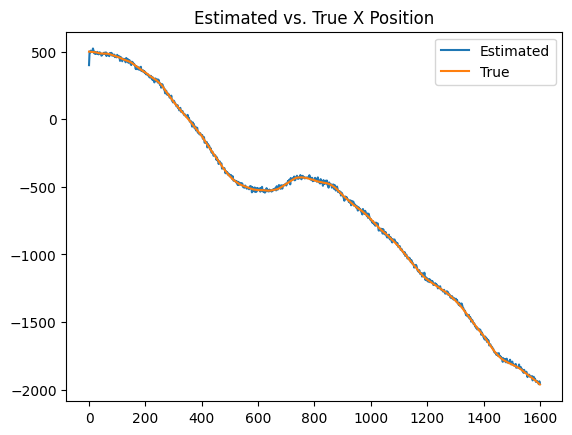

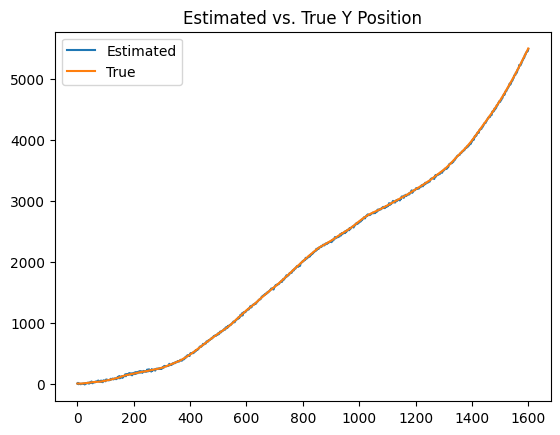

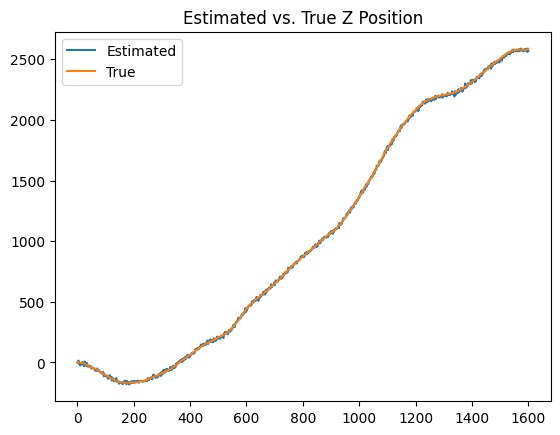

In [361]:
t = hcw_dynamics.t_array

start = 1
plt.title("Estimated vs. True X Position")
plt.plot(t, x_arr.T[0])
plt.plot(t, X[:,0])
plt.legend(["Estimated","True"])
plt.show()


plt.title("Estimated vs. True Y Position")
plt.plot(t, x_arr.T[1])
plt.plot(t, X[:,1])
plt.legend(["Estimated","True"])
plt.show()

plt.title("Estimated vs. True Z Position")
plt.plot(t, x_arr.T[2])
plt.plot(t, X[:,2])
plt.legend(["Estimated","True"])
plt.show()

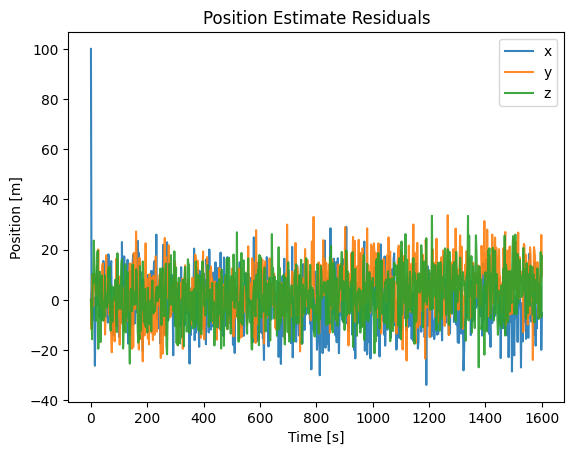

RMS error per axis (position):
x: 10.9036472070678
y: 11.161373878025369
z: 10.1306664032887


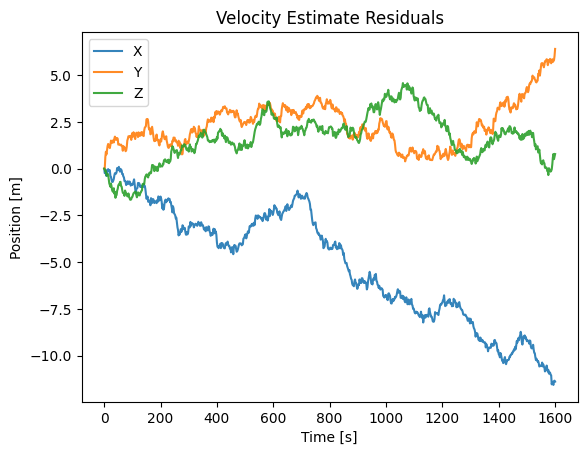

RMS error per axis (velocity):
x: 5.978704115060286
y: 2.637223665645965
z: 2.099866394537854


In [362]:
# Error analysis
err = X - x_arr

plt.title("Position Estimate Residuals")
plt.plot(t, err[:,:3], alpha=0.9)
plt.legend(["x", "y", "z"])
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.show()

print("RMS error per axis (position):")
print("x:", np.sqrt(np.mean(err[:,0]**2)))
print("y:", np.sqrt(np.mean(err[:,1]**2)))
print("z:", np.sqrt(np.mean(err[:,2]**2)))

plt.title("Velocity Estimate Residuals")
plt.plot(t, err[:,3:6], alpha=0.9)
plt.legend(["X", "Y", "Z"])
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.show()

print("RMS error per axis (velocity):")
print("x:", np.sqrt(np.mean(err[:,3]**2)))
print("y:", np.sqrt(np.mean(err[:,4]**2)))
print("z:", np.sqrt(np.mean(err[:,5]**2)))